# Exploring Open Web RX waterfall data
An exercise in data aquisition and signals processing.

## Metadata collection

First off we will select a site and get some metadata to assess if we can use it.

In [ ]:
# Lets explore some open web rx data.
# we could visit and scrape https://www.receiverbook.de/?type=openwebrx for links... 
# but lets leave that for later and go straight to a single source. 

import json
import httpx

# "randomly" chosen openwebrx site
site = "https://2.websdr.jestok.com"

# Let's fetch the features of the site first
result = httpx.get(site + "/api/features")
result.raise_for_status()
features = result.json()

In [2]:
features

{'core': {'available': True,
  'requirements': {'csdr': {'available': True,
    'enabled': True,
    'description': 'OpenWebRX uses the demodulator and pipeline tools provided by the\n[CSDR](https://github.com/jketterl/csdr) project. In addition, the\n[PyCSDR](https://github.com/jketterl/pycsdr) must be installed to\nprovide CSDR Python bindings. The `python3-csdr` package, found in\nthe OpenWebRX repositories, should be all you need. Do not forget\nto restart OpenWebRX after installing this package.'}}},
 'rtl_sdr': {'available': True,
  'requirements': {'rtl_connector': {'available': True,
    'enabled': True,
    'description': 'The [OWRX Connector](https://github.com/jketterl/owrx_connector)\nprovides direct interfacing between RTL-SDR hardware and OpenWebRX.\nYou can install the `owrx-connector` package from the OpenWebRX\nrepositories.'}}},
 'rtl_sdr_soapy': {'available': False,
  'requirements': {'soapy_connector': {'available': True,
    'enabled': True,
    'description': 'The

In [ ]:
# Now lets get some metrics from the openwebrx device to see how its doing.
result = httpx.get(site + "/metrics.json")
result.raise_for_status()
metrics = result.json()
metrics
# Note that if the user count is high, we might want to consider a different site.

{'openwebrx': {'users': 2},
 'pskreporter': {'duplicates': {'count': 132460}, 'spots': {'count': 1238620}},
 'wsprnet': {'spots': {'count': 0}},
 'decoding': {'queue': {'length': 0,
   'in': {'count': 178553},
   'out': {'count': 178553},
   'overflow': {'count': 0},
   'error': {'count': 2}}},
 'wsjt': {'decodes': {'17m': {'FT8': {'count': 400422}},
   '20m': {'FT8': {'count': 1027444}, 'FT4': {'count': 881}},
   '40m': {'FT8': {'count': 761553}, 'FT4': {'count': 2}},
   '30m': {'FT8': {'count': 205491}},
   'unknown': {'FT8': {'count': 14}}}}}

In [ ]:
# Lets get some metadata to see where the receiver is located. (asl = above sea level)
result = httpx.get(site + "/status.json")
result.raise_for_status()
status = result.json()
status["receiver"]

{'name': 'SR4DON OLSZTYN/POLAND 17m-160m',
 'admin': 'sdr@jestok.com',
 'gps': {'lat': 53.7832485938901, 'lon': 20.4547299031047},
 'asl': 134,
 'location': 'Olsztyn, Poland'}

Okay, the status json should look something line this:
```
{'name': 'SR4DON OLSZTYN/POLAND 17m-160m',
 'admin': 'sdr@jestok.com',
 'gps': {'lat': 53.7832485938901, 'lon': 20.4547299031047},
 'asl': 134,
 'location': 'Olsztyn, Poland'}
```
So it looks like this particular receiver is located in Poland so lets move on with that.

## Waterfall data

Lets have a look at what the web viewer is getting when opening up the site. 
When you visit an openwebrx page you are greeted by this wonderfull (near) real-time waterfall.
So lets have a look at that datastream, shall we 

In [ ]:
# Get 20 items from the websocket stream
from websockets.asyncio.client import connect

messages = []
async with connect("wss://2.websdr.jestok.com/ws/") as ws:
    await ws.send("SERVER DE CLIENT client=lib/FrequencyDisplay.js type=receiver")
    for _ in range(20):
        msg = await ws.recv()
        messages.append(msg)

print(len(messages))

20


In [11]:
messages

['CLIENT DE SERVER server=openwebrx version=v1.2.85',
 '{"type": "receiver_details", "value": {"usage_policy_url": "policy", "receiver_location": "Olsztyn, Poland", "receiver_name": "SR4DON OLSZTYN/POLAND 17m-160m", "keep_files": 20, "receiver_asl": 134, "photo_desc": "<script async src=\\"https://www.googletagmanager.com/gtag/js?id=G-XQYYP2HWLQ\\"></script>\\r\\n<script>\\r\\n  window.dataLayer = window.dataLayer || [];\\r\\n  function gtag(){dataLayer.push(arguments);}\\r\\n  gtag(\'js\', new Date());\\r\\n  gtag(\'config\', \'G-XQYYP2HWLQ\');\\r\\n</script>\\r\\n<p>\\r\\n\\r\\n<a href=\\"https://1.websdr.jestok.com\\"><img src=\\"https://dabuttonfactory.com/button.png?t=PRZE%C5%81%C4%84CZ+NA+SDR+1&f=Open+Sans-Bold&ts=22&tc=fff&hp=45&vp=20&c=11&bgt=unicolored&bgc=00f&bs=1&bc=569\\" alt=\\"PRZE\\u0141\\u0104CZ NA SDR 1\\" width=\\"303\\" height=\\"64\\" /></a>\\u00a0\\r\\n\\r\\n<a href=\\"https://3.websdr.jestok.com\\"><img src=\\"https://dabuttonfactory.com/button.png?t=PRZE%C5%81%C4

Great scott! its really quite fast... we get a bunch more metadata like the the position of the receiver, some dial frequencies, bands etc.. Then we get a bunch of binary data! cool... but what is it? 
```
b'\x01\xff\xff\xff\xff\x0e\x08\x08\x08\x08\x88\x00\x08\x08...
```

well, we did get a hint in the config dictionary that came before the data: 
```
"waterfall_scheme": "TeejeezWaterfall", "tuning_precision": 2, "fft_size": 16384, "audio_compression": "adpcm", "waterfall_auto_levels": {"min": 3.0, "max": 10.0}
```

In [12]:
# Select a binary string to proceed with
message = messages[14]
message

b'\x01\xff\xff\xff\xff\x0e\x08\x08\x08\x08\x88\x00\x08\x08\x88\x00\x08\x88\x00\xa1\x00\x80\x08\x91\x19\x80\x08\x81\x88\rt\xe9\x01\x18\x80\x1a\x11\xa9\x03z0\x9f\x00\x88\x80\x08\x80\x02\x88\xb8,@\xbaX\x1d9\tr\x07\x8d\x18\x88\x81\x99\x11;\xa2\x9aW\xa1\xa8\n\xa8\x11\t\x99\x80\x1by\xc5\x10\x1a\x00\x82\xd9A\x1b\x82\x82\x0f:\xa0\x088:\xac!\xa0\x97\txw\x94\xc8\x8a\x08\x80\x90\x00\x00\x89\x08\x82\x1a\xc4)\xa2H\xc9\xb3\xa2p\x98\xa2\x81\xb0\xa6\x890\x00\xe0\xa1\x91\x10)+1\xc7\x89\x12u\xb9\x92\xba\x18\xd3\x12\xa2\x1e\x11\xf8(\x00\x9a8\x92\x01\xa0?\x1a\x81\xe1\x92H\x88\xd8\x12+)\xc1\x0088\x9dR\x9a\x94\xa9\x80\xf0\x81\x11:\x93\xae"L\x88\xa86\x8a,\x90\x95\x1e\x01\x08\t\xf1 \x81\x80=\xa8!\xc1!\x19\xf8\xa1 \x8a\xa5,\x08[\x89)\xb4\x82\x89\x08\x92\x90sM\x19\x1aK\x19=\xb0h\x9a\x88\x93Y\xa3\x9a\x1bx\x81\x9dH\x10:\x1c\x92\t\xb9z\x82\xb8)[\x13\xc2*\x9d*\xc2P\xa0\x80\x01\x18\xc2[\x05\x1d\xb1\x90\x80\x96\xa0\x11\x8a\x82pw\x9d\x81\x00\x08\x80\x91\x80(\xab\x00\x02\x82\x8c\x86\x88\x89\x05\xa0\x08\xa0\x88\x07\xf1!

In [13]:
# Load the config and get the start frequency
config = json.loads(messages[6])
center_freq = config["value"]["center_freq"]
start_freq = config["value"]["start_freq"]
bandwidth = 2*(center_freq - start_freq)
stop_freq = start_freq + bandwidth
print(f"{start_freq} - {bandwidth} - {stop_freq}")

14074000 - 1052000 - 15126000


In [14]:
# We want to get some data from this 
info = json.loads(messages[2])
fft_compression = info["value"]["fft_compression"]
fft_size = info["value"]["fft_size"]
position = info["value"]["receiver_gps"]
info_profile = json.loads(messages[6])
profile = info_profile["value"]
profile

{'sdr_id': 'rtl_sdr_a',
 'waterfall_levels': {'min': -72.0, 'max': -7.0},
 'center_freq': 14600000,
 'start_freq': 14074000,
 'profile_id': '20m_a',
 'tuning_step': 50,
 'samp_rate': 9000000,
 'start_mod': 'usb',
 'start_offset_freq': -526000}

In [15]:
# select one of the data rows for processing and load it into an array
import numpy as np
data_array = np.frombuffer(message[1:], dtype=np.uint8)
data_array[25:50]


array([  8, 129, 136,  13, 116, 233,   1,  24, 128,  26,  17, 169,   3,
       122,  48, 159,   0, 136, 128,   8, 128,   2, 136, 184,  44],
      dtype=uint8)

What the... what on earth is this? 
8, 129, 136,  13, 116, 233,   1,  24, 128,  26,  17, 169,   3,   122,  48, 159,   0, 136, 128,   8, 128,   2, 136, 184,  44

Exciting! But the hint came in the metadata before: "audio_compression": "adpcm"
This is an adaptive differential pulse-code modulation. A very effivient supposedly lossless compression for a digital signal.
Well thats cool! Right?!... just me? okaaay... whatever, you're the one reading this. lets parse it.  

In [19]:
# right about now is a goot time to start timing how long it takes to process the data.
from time import perf_counter_ns

In [27]:
# The bitstream is a split-band ADPCM stream. So we have to split the bytes into 4 bit nibbles. 
def split_nibbles(byte_array):
    high_nibbles = np.bitwise_and(byte_array, 0xF0) >> 4
    low_nibbles = np.bitwise_and(byte_array, 0x0F)
    return high_nibbles, low_nibbles

tic = perf_counter_ns()
higher, lower = split_nibbles(data_array)
toc = perf_counter_ns()
print(f"Split nibbles took {(toc - tic)/1000} microseconds")

Split nibbles took 193.8 microseconds


In [28]:
tic = perf_counter_ns()
interleaved = np.array([val for pair in zip(lower, higher) for val in pair], dtype=np.uint8)
toc = perf_counter_ns()
print(f"interleaving took {(toc - tic)/1000} microseconds")
interleaved

interleaving took 2023.1 microseconds


array([15, 15, 15, ...,  2, 15,  8], shape=(16394,), dtype=uint8)

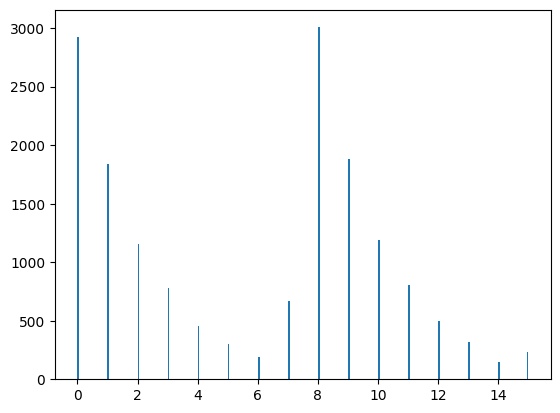

In [30]:
import matplotlib.pyplot as plt 
plt.figure()
plt.hist(interleaved, bins=255)
plt.show()

In [31]:
# I found a python library that can decode ADPCM data, but its not packaged.
# I've downloaded the adpcm.py file and added it to the root of this project, which is the one i'll be using here now.
# The adpcm library is from https://github.com/karnwatcharasupat/pyADPCM
from adpcm import ADPCM

# perform an adpmc decode operation on the interleaved data...add()
# Remove the first 10 numbers from the list and devide every number by 100

adpcm = ADPCM()
#fft = adpcm.decode(interleaved)[10:]/100


fft = np.array(adpcm.decode(interleaved), dtype=np.float32)[10:]/100
print(len(fft), fft)

16384 [-107.69 -101.61 -107.14 ... -104.28 -105.29 -105.43]


In [32]:
frequency_range = np.linspace(start_freq, stop_freq, fft_size)/1000000

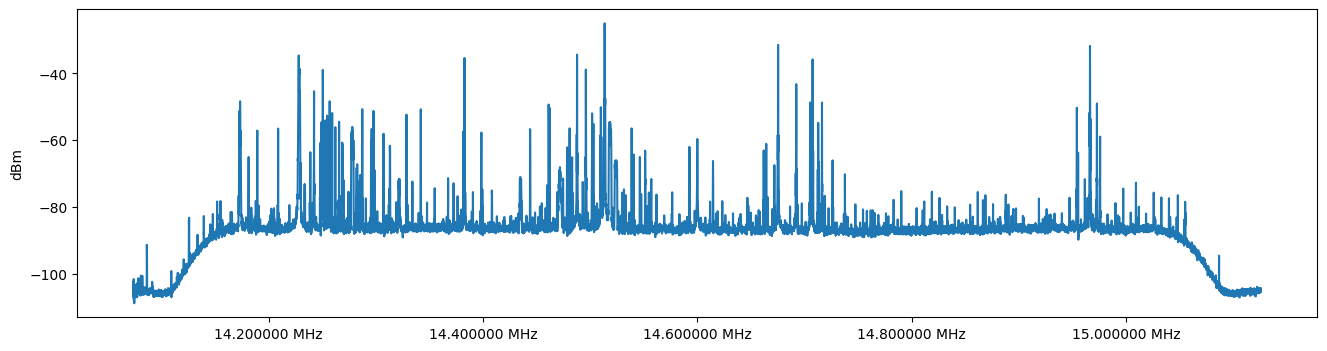

In [33]:
# Now plot the completed data array and you should see a spectral plot
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

fig, ax = plt.subplots(figsize=(16,4))
plt.ylabel("dBm")
line1, =ax.plot(frequency_range, fft)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter("%f MHz"))
plt.show()  

In [37]:
# All togheter now...add()
import time

tic = time.perf_counter()
data_array = np.frombuffer(message[1:], dtype=np.uint8)
higher, lower = split_nibbles(data_array)
interleaved = np.array([val for pair in zip(lower, higher) for val in pair], dtype=np.uint8)
fft = np.array(adpcm.decode(interleaved), dtype=np.float32)[10:]/100
toc = time.perf_counter()
print(toc - tic)

0.051981299999170005


In [ ]:
import numpy as np
import time
import nibbler
import radpcm
def decode_fft_bitstream(message: bytes) -> np.ndarray[np.int16]: 
    # strip the first character and load into array
    interleaved = nibbler.split_and_interleave_nibbles(message)
    fft = radpcm.decode(interleaved)[10:]/100
    return fft
tic = time.perf_counter()
decode_fft_bitstream(message[1:])
toc = time.perf_counter()
print(toc - tic)

# Realtime processing
lets do if fr this time 

In [ ]:
import numpy as np
import nibbler
import radpcm

import matplotlib.pyplot as plt
import httpx
import websocket
 

In [ ]:
import json
def handle_info(message: str, receiver: dict) -> dict:
    info = json.loads(message)
    info_type = info["type"]
    match info_type:
        case "config" | "receiver_details":
            for key, value in info["value"]: 
                receiver[key] = value
            return receiver
        case "cpuusage" | "temp":
            receiver[info_type] = info["value"]
            return receiver
        case _:
            return receiver

In [ ]:
# Configure site url from dashboard. 
# Get receiver info on demand. 

site = "2.websdr.jestok.com"
result = httpx.get("https://" + site + "/status.json")
result.raise_for_status()
status = result.json()
receiver = status["receiver"]
receiver

{'name': 'SR4DON OLSZTYN/POLAND 17m-160m',
 'admin': 'sdr@jestok.com',
 'gps': {'lat': 53.7832485938901, 'lon': 20.4547299031047},
 'asl': 160,
 'location': 'Olsztyn, Poland'}

In [ ]:

# Make this toggleable from the dashboard.
raise ValueError

ws = websocket.create_connection("wss://" + site + "/ws/")
try: 
    ws.send("SERVER DE CLIENT client=lib/FrequencyDisplay.js type=receiver")
    while True:
        msg = ws.recv()    
        match message[0]:
            case 1:
                fft = decode_fft_bitstream(message[1:])
                # What to do with the decoded fft...
                # Send it to a function that updates the plot in a dashboard. 
                # Plotly seems like a good option.
            case "{":
                # Update receiver information.
                receiver = handle_info(message, receiver)
            case "C":
                print(message)
            case _:
                print("Message not handled: ", message)
except Exception as err:
    raise err
finally: 
    ws.close()


ValueError: 

In [ ]:
# Now plot the completed data array and you should see a spectral plot
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np

MEASUREMENT_TIME = 50
INTERVAL_SEC = 0.1
x = np.linspace(0, 6*np.pi, 100)
y = np.sin(x)

# You probably won't need this if you're embedding things in a tkinter plot...
plt.ion()

fig = plt.figure()
ax = fig.add_subplot(111)
line1, = ax.plot(x, y, 'r-') # Returns a tuple of line objects, thus the comma

for i in range(MEASUREMENT_TIME):
    data = np.random.rand(100)

    plt.plot(data)

    # figure appearence adjustments
    plt.ylim(-0.2, 1.2)
    plt.title(f'FRAME {i+1}')

    # to avoid clearing last plot
    if (i != MEASUREMENT_TIME-1):
        plt.draw()
        plt.pause(INTERVAL_SEC)
        plt.cla()
    else:
        plt.show()


In [ ]:
# importing libraries
import numpy as np
import time
import matplotlib.pyplot as plt
 
# creating initial data values
# of x and y
x = np.linspace(0, 10, 100)
y = np.sin(x)
 
# to run GUI event loop
plt.ion()
 
# here we are creating sub plots
figure, ax = plt.subplots(figsize=(10, 8))
line1, = ax.plot(x, y)
 
# setting title
plt.title("Geeks For Geeks", fontsize=20)
 
# setting x-axis label and y-axis label
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
 
# Loop
for n in range(50):
    # creating new Y values
    new_y = np.sin(x-0.5*n)
 
    # updating data values
    line1.set_xdata(x)
    line1.set_ydata(new_y)
 
    # drawing updated values
    figure.canvas.draw()
 
    # This will run the GUI event
    # loop until all UI events
    # currently waiting have been processed
    figure.canvas.flush_events()
 
    time.sleep(0.1)

## TODO

- Find a way to create a dashboard
- make the dashboard interactive to enter, start and stop a websocket connection.
- make a realtime spectrogram
- create a self updating waterfall plot (fixed window)

and once thats done. 
- Create a database to keep the data in.
- Create an ingest tool that loads into the database
- Create a way for the dashboard to query the waterfall database and produce an image.
- Join that new waterfall viz with the updating one using a subscription to the waterfall stream. 

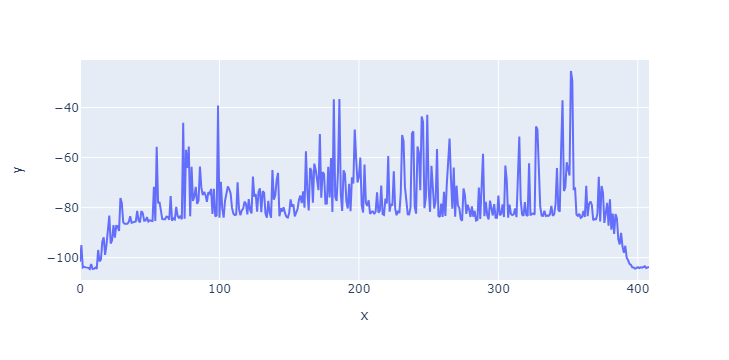

In [ ]:
# plotly
import plotly.express as px
# Resample size (e.g., take max of every 100 points)
chunk_size = 40
data = fft
# Reshape and take the max
reduced_data_max = data[:len(data) // chunk_size * chunk_size].reshape(-1, chunk_size).max(axis=1)
px.line(y=reduced_data_max)


In [ ]:
len(fft)

16384